<a href="https://colab.research.google.com/github/syedabusafwan/ML-practice/blob/main/Dr_binary_96_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

# Importing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
 95% 405M/427M [00:02<00:00, 187MB/s]
100% 427M/427M [00:02<00:00, 187MB/s]


In [6]:
!unzip /content/diabetic-retinopathy-224x224-gaussian-filtered.zip

Archive:  /content/diabetic-retinopathy-224x224-gaussian-filtered.zip
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0369f3efe69b.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/03e25101e8e8.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/04ac765f91a1.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/05a5183c92d0.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0684311afdfc.png  
  inflating: gaussian_filtered_images/gaussian_filtered_imag

# Preprocessing

In [7]:
image_dir = Path('/content/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [8]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/content/gaussian_filtered_images/gaussian_fil...,Proliferate_DR
1,/content/gaussian_filtered_images/gaussian_fil...,Moderate
2,/content/gaussian_filtered_images/gaussian_fil...,Moderate


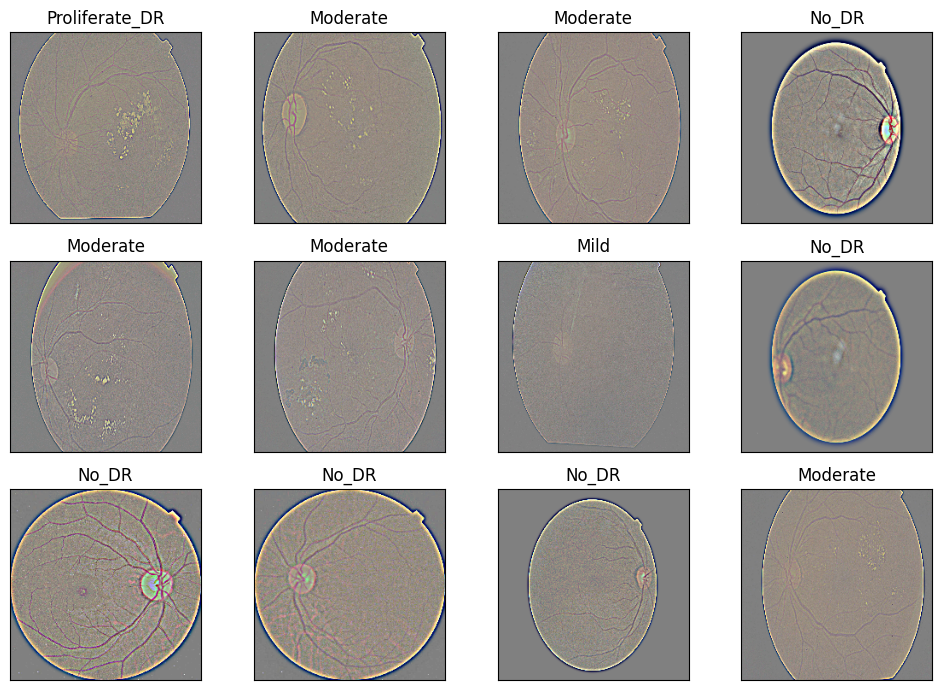

In [9]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

<ipython-input-10-2344376753>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


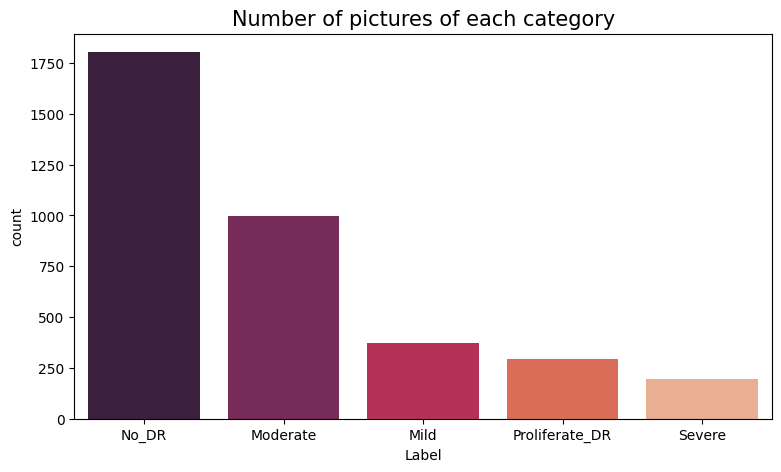

In [10]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [11]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

# Training & Testing

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},

}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]


Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 74s 470ms/step - accuracy: 0.6544 - loss: 0.9465 - val_accuracy: 0.7143 - val_loss: 0.7607
DenseNet121          trained in 74.34 sec
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.6465 - loss: 1.0081 - val_accuracy: 0.7508 - val_loss: 0.7195
MobileNetV2          trained in 26.26 sec
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 92s 638ms/step - accuracy: 0.6813 - loss: 0.8792 - val_accuracy: 0.7538 - val_loss: 0.6177
DenseNet169          trained in 100.27 sec
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.6323 - loss: 0.9657 - val_accuracy: 0.7629 - val_loss: 0.7181
DenseNet201          trained in 138.57 sec
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 72s 515ms/step - accuracy: 0.4763 - loss: 1.3285 - val_accuracy: 0.4650 - val_loss: 1.3400
EfficientNetB0       trained in 72.02 sec
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/s

In [ ]:
models = {
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}

}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 94s 526ms/step - accuracy: 0.5682 - loss: 1.1336 - val_accuracy: 0.5957 - val_loss: 1.0675
EfficientNetB7       trained in 94.04 sec
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 493ms/step - accuracy: 0.6305 - loss: 1.0682 - val_accuracy: 0.7143 - val_loss: 0.7702
InceptionResNetV2    trained in 101.17 sec
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.6622 - loss: 1.0383 - val_accuracy: 0.7325 - val_loss: 0.7593
InceptionV3          trained in 49.37 sec
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - accuracy: 0.6777 - loss: 0.8667 - val_accuracy: 0.7386 - val_loss: 0.6816
MobileNet            trained in 23.67 sec
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.6684 - loss: 0.9912 - val_accuracy: 0.7295 - val_loss: 0.7037
MobileNetV2          trained in 26.75 sec
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0u

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# Two levels Training

In [12]:
# Map the labels to have only "No_DR" and "DR"
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(5)

,Filepath,Label
0,/content/gaussian_filtered_images/gaussian_fil...,DR
1,/content/gaussian_filtered_images/gaussian_fil...,DR
2,/content/gaussian_filtered_images/gaussian_fil...,DR
3,/content/gaussian_filtered_images/gaussian_fil...,No_DR
4,/content/gaussian_filtered_images/gaussian_fil...,DR


<ipython-input-13-3781743369>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


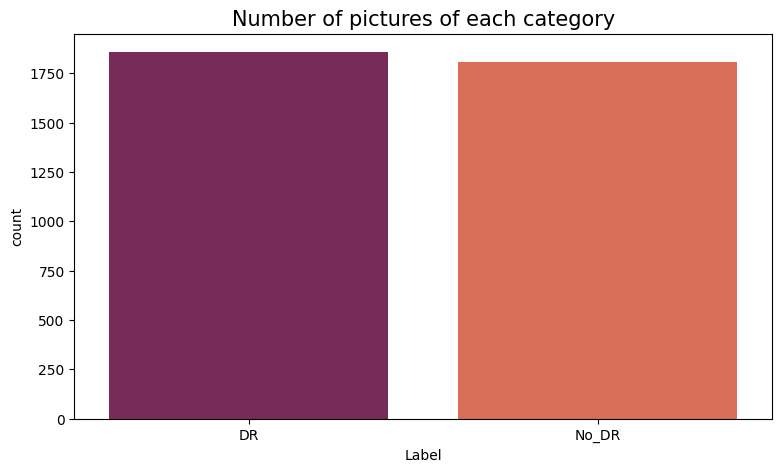

In [13]:
# Display the number of pictures of each category
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [14]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [15]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8762 - loss: 0.2695 - val_accuracy: 0.9544 - val_loss: 0.1450
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9579 - loss: 0.1291 - val_accuracy: 0.9514 - val_loss: 0.1564
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9580 - loss: 0.1235 - val_accuracy: 0.9605 - val_loss: 0.1235
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9654 - loss: 0.1049 - val_accuracy: 0.9544 - val_loss: 0.1494
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9730 - loss: 0.0817 - val_accuracy: 0.9574 - val_loss: 0.1158
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9738 - loss: 0.0768 - val_accuracy: 0.9605 - val_loss: 0.1522
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9663 - loss: 0.0932 - val_accuracy: 0.9544 - val_loss: 0.1408
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9764 - loss: 0.0639 - val_accuracy: 0.9605 - v

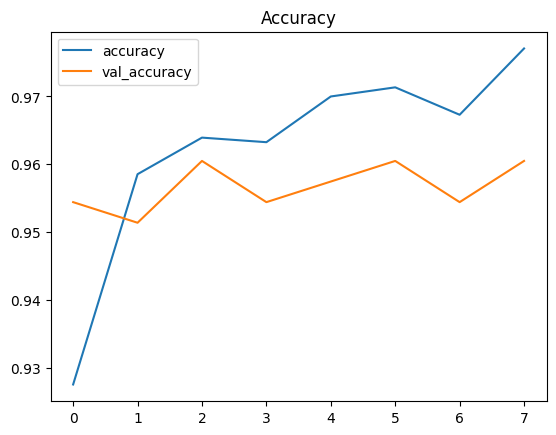

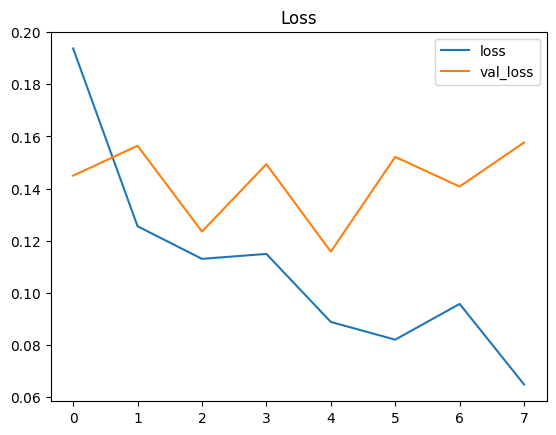

 ## Test Loss: 0.14252

## Accuracy on the test set: 95.64%



12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
The first 5 predictions: ['No_DR', 'DR', 'DR', 'No_DR', 'No_DR']
              precision    recall  f1-score   support

          DR       0.94      0.97      0.95       174
       No_DR       0.97      0.95      0.96       193

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



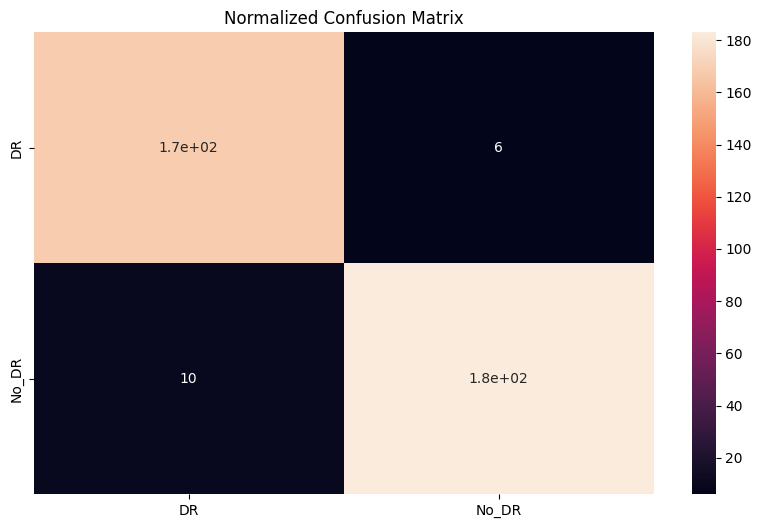

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

cf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

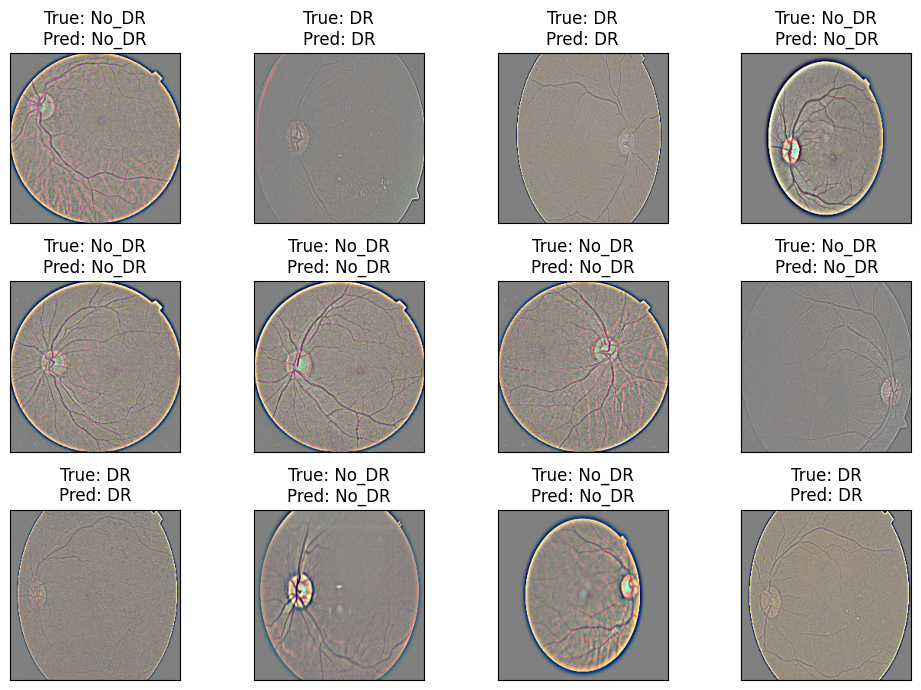

In [17]:
# prompt: predict some image also with true positive result

# Display some pictures of the dataset with their predictions
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPred: {pred[i]}")
plt.tight_layout()
plt.show()